# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Loading the Data After EDA

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset
df=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/total_data_guayas_region.csv')

In [4]:
df.head()

,store_nbr,item_nbr,date,unit_sales,year,month,day,day_of_week,lag_1,lag_7,lag_14,rolling_avg_7,rolling_stdv_7
0,24,105574,2013-01-16,19.0,2013,1,16,2,3.0,7.0,12.0,5.857143,6.175990
1,24,105574,2013-01-17,7.0,2013,1,17,3,19.0,3.0,1.0,6.428571,6.051367
2,24,105574,2013-01-18,8.0,2013,1,18,4,7.0,6.0,3.0,6.714286,6.074929
3,24,105574,2013-01-19,5.0,2013,1,19,5,8.0,7.0,4.0,6.428571,6.106203
4,24,105574,2013-01-20,3.0,2013,1,20,6,5.0,1.0,7.0,6.714286,5.851333


In [5]:
df.shape

(5058680, 13)

In [6]:
df.isna().sum()

,0
store_nbr,0
item_nbr,0
date,0
unit_sales,0
year,0
month,0
day,0
day_of_week,0
lag_1,0
lag_7,0


In [7]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058680 entries, 0 to 5058679
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   store_nbr       int64  
 1   item_nbr        int64  
 2   date            object 
 3   unit_sales      float64
 4   year            int64  
 5   month           int64  
 6   day             int64  
 7   day_of_week     int64  
 8   lag_1           float64
 9   lag_7           float64
 10  lag_14          float64
 11  rolling_avg_7   float64
 12  rolling_stdv_7  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 501.7+ MB


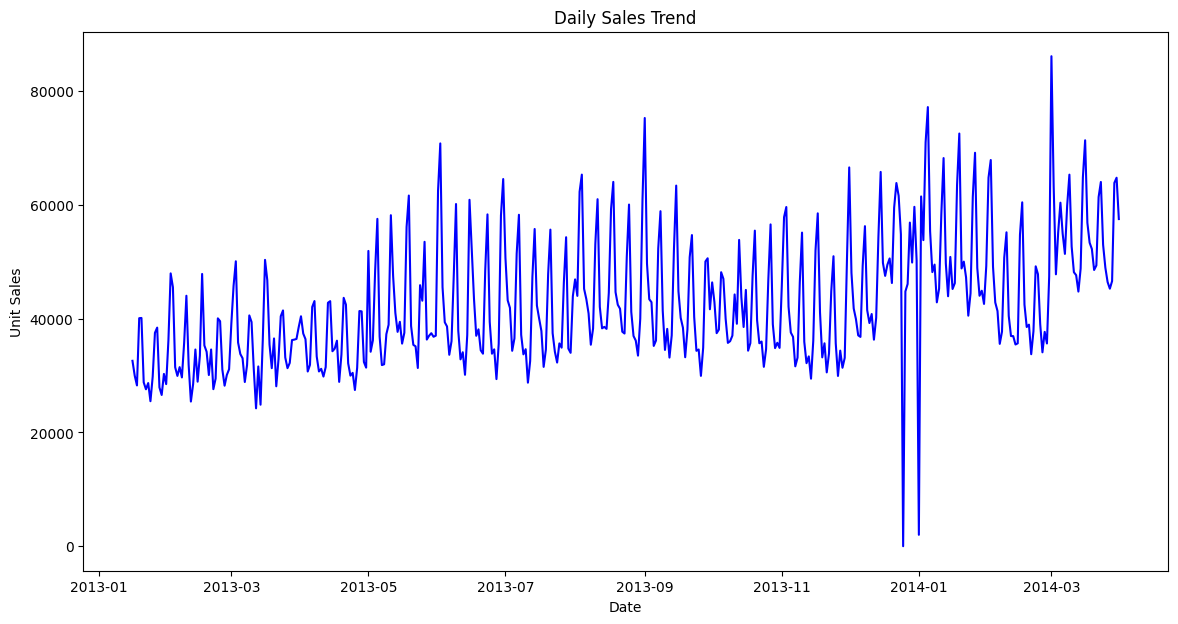

In [8]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by date and aggregate unit sales
df_daily_sales = df.groupby('date')['unit_sales'].sum().reset_index()

# Set date as index and fill missing dates with zero sales
df_daily_sales.set_index('date', inplace=True)
df_daily_sales = df_daily_sales.asfreq('D').fillna(0)

# Visualize sales trend
plt.figure(figsize=(14, 7))
sns.lineplot(x=df_daily_sales.index, y=df_daily_sales['unit_sales'], color='blue')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

In [9]:
df.columns

Index(['store_nbr', 'item_nbr', 'date', 'unit_sales', 'year', 'month', 'day',
       'day_of_week', 'lag_1', 'lag_7', 'lag_14', 'rolling_avg_7',
       'rolling_stdv_7'],
      dtype='object')

# Training and Evaluation of XGBoost Model for Sales Prediction with RMSE and MAE Metrics

In [10]:
# Lets choose one item and one store
df_for_model = df

df_for_model["date"] = pd.to_datetime(df_for_model["date"])

#Train data are till 2014-01-01 and test data are after that date
train_data = df_for_model[df_for_model['date'] < '2014-01-01']
test_data = df_for_model[df_for_model['date'] >= '2014-01-01']

#Split for target and features
X_train = train_data.drop(['unit_sales','date'], axis = 1)
y_train = train_data['unit_sales']
X_test = test_data.drop(['unit_sales','date'], axis = 1)
y_test = test_data['unit_sales']

# Manually specify hyperparameters
model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, learning_rate=0.1,  max_depth=3)

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Train dataframe shape:",train_data.shape)
print("Test dataframe shape:",test_data.shape)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Train dataframe shape: (4023950, 13)
Test dataframe shape: (1034730, 13)
RMSE: 5.98
MAE: 2.24


# Hyperparameter Tuning and Model Evaluation using GridSearchCV with TimeSeriesSplit for RMSE Optimization

In [11]:
#Grid search for best parameters
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.1, 0.2],
    'max_depth': [3, 5, ]
}

# TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=4, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Best model after tuning
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_best = best_model.predict(X_test)

# Calculate RMSE for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Best Model RMSE: {rmse_best}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters from GridSearchCV: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best Model RMSE: 5.75685128190247


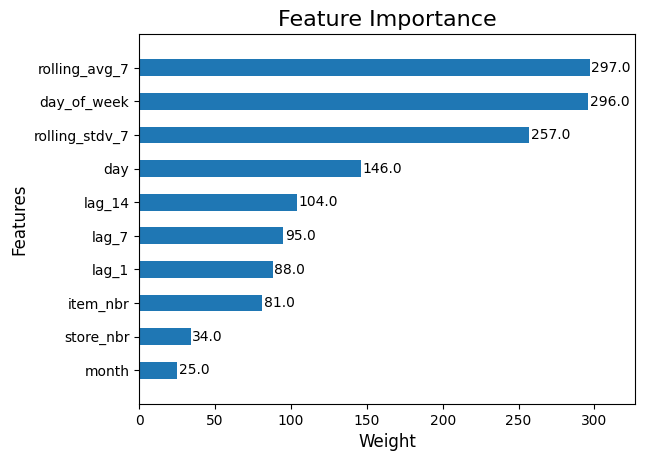

In [12]:
# Plot feature importance
xgb.plot_importance(best_model,
                    importance_type='weight',
                    title='Feature Importance',
                    height=0.5)
# Customize the plot appearance
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Weight', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Disable gridlines

# Display the plot
plt.show()

# Visualizing Actual vs Predicted Sales with XGBoost for the period 1st Jan 2014 to 31st March 2014

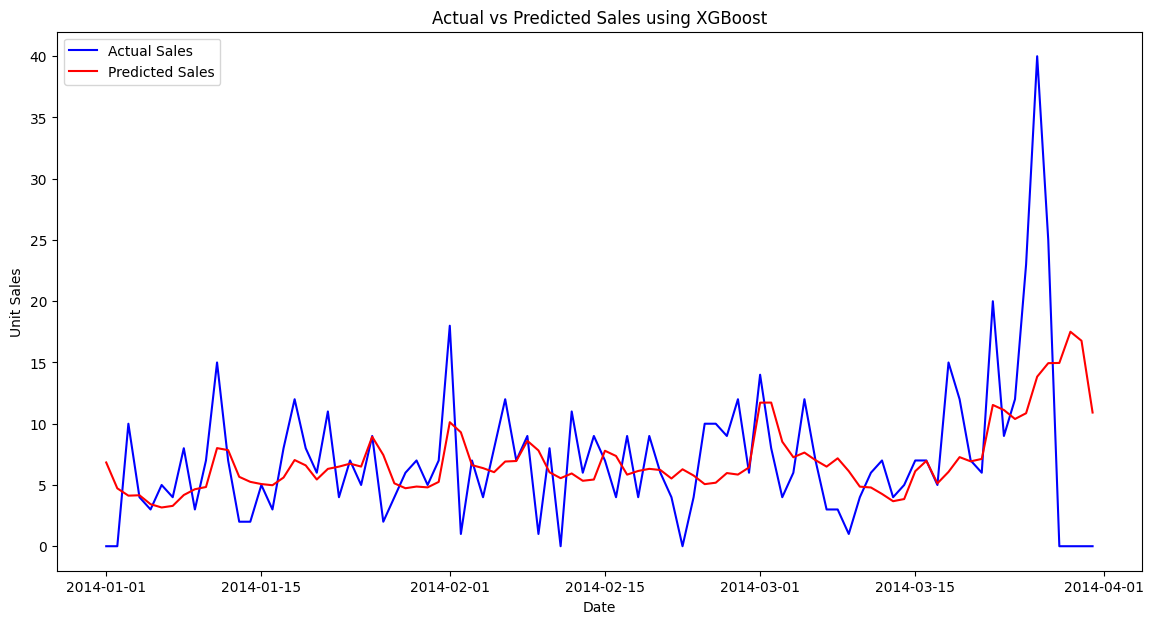

In [16]:
# After grid search and model fitting
y_pred_best = best_model.predict(X_test)

# Create a DataFrame for actual vs predicted sales
df_results = pd.DataFrame({
    'date': test_data['date'],  # Assuming test_data contains the 'date' column
    'unit_sales': y_test,  # Actual sales
    'predicted_sales': y_pred_best  # Predicted sales
})

# Set the 'date' column as the index
df_results.set_index('date', inplace=True)

# Remove duplicate dates (if any)
df_results = df_results[~df_results.index.duplicated(keep='first')]

# Set a daily frequency and fill missing values
df_results = df_results.asfreq('D').fillna(0)

# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(df_results.index, df_results['unit_sales'], label='Actual Sales', linestyle='-', color='blue')
plt.plot(df_results.index, df_results['predicted_sales'], label='Predicted Sales', linestyle='-', color='red')

plt.title('Actual vs Predicted Sales using XGBoost')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()

# Saving the Best XGBoost Model in Multiple Formats (.pkl and .xgb)

In [18]:
# Save the best model as a .pkl file using joblib
pkl_model_path = '/content/drive/MyDrive/retail_kaggle_data/xgb_model.pkl'
joblib.dump(best_model, pkl_model_path)
print(f"Model saved as .pkl to {pkl_model_path}")

# Save the best model as a .xgb file using the save_model method
xgb_model_path = '/content/drive/MyDrive/retail_kaggle_data/xgb_model.xgb'
best_model.save_model(xgb_model_path)
print(f"Model saved as .xgb to {xgb_model_path}")

Model saved as .pkl to /content/drive/MyDrive/retail_kaggle_data/xgb_model.pkl
Model saved as .xgb to /content/drive/MyDrive/retail_kaggle_data/xgb_model.xgb
